# Self-Organizing Maps for Disease Clustering

In this project, I use a Self-Organizing Map (SOM) to cluster diseases based on their genetic associations with Human Leukocyte Antigen (HLA) alleles. The dataset used in this analysis is the HLA-PheWAS catalog, which contains information about the associations betIen HLA alleles and various diseases.

### Importing Libraries
To start, I import all the necessary libraries that will be used throughout the analysis. These include libraries for data manipulation, machine learning, visualization, and self-organizing maps (SOM).

In [56]:
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from minisom import MiniSom
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


## Data Preprocessing and Analysis

In this section, I load the HLA-PheWAS catalog dataset, preprocess the data, and analyze the associations between HLA alleles and diseases. The goal is to prepare the data for clustering using a Self-Organizing Map (SOM).

### Load the Dataset
I load the cleaned HLA-PheWAS catalog dataset into a DataFrame and display the first few rows to inspect its structure and contents.


In [57]:
df = pd.read_csv('Data/hla-phewas-catalog-cleaned.csv')
print(df.head()) # Display the first few rows of the dataset


          snp  phewas_code         phewas_string  cases  controls  \
0    HLA_A_01          8.0  Intestinal infection    683     27384   
1  HLA_A_0101          8.0  Intestinal infection    683     27384   
2    HLA_A_02          8.0  Intestinal infection    683     27384   
3  HLA_A_0201          8.0  Intestinal infection    683     27384   
4    HLA_A_03          8.0  Intestinal infection    683     27384   

       category_string  odds_ratio       p    l95    u95 gene_name     maf a1  \
0  infectious diseases       0.887  0.1654  0.749  1.051         A  0.1655  P   
1  infectious diseases       0.882  0.1470  0.745  1.045         A  0.1653  P   
2  infectious diseases       0.928  0.3378  0.797  1.081         A  0.3025  P   
3  infectious diseases       0.919  0.2778  0.789  1.070         A  0.2906  P   
4  infectious diseases       1.107  0.2359  0.936  1.310         A  0.1435  P   

  a2  chromosome  nchrobs  gene_class  serotype  subtype  
0  A           6    57678           1  

### Filter The Dataset
In this step, I filter the dataset to keep only rows with 4-digit HLA alleles and associations that are statistically significant (p-value < 0.05). Additionally, I clean the `snp` column by removing the prefix "HLA_".


In [58]:
filtered_df = df[df['subtype'] != 0] # Keep only 4-digit HLA alleles
filtered_df = filtered_df[filtered_df['p'] < 0.05] # Only keep statistically significant associations
filtered_df['snp'] = filtered_df['snp'].str.replace('HLA_', '') # Remove the prefix "HLA_"


### Group by Disease
I group the data by the `phewas_string` column, which represents different diseases, and aggregate the corresponding alleles, gene names, p-values, odds ratios, confidence intervals, and minor allele frequencies. This gives us a consolidated view of each disease and its associated genetic data.


In [59]:
grouped_df = filtered_df.groupby('phewas_string').agg({
    'snp': list,
    'gene_name': list,
    'p': list,
    'odds_ratio': list,
    'category_string': 'first',
    'l95': list,
    'u95': list,
    'maf': list,
}).reset_index()


### Identify All Unique Alleles and One-Hot Encode Categorical Variables
I identify all unique HLA alleles across the dataset and then apply one-hot encoding to the `gene_name` and `category_string` columns. This encoding transforms the categorical variables into a format suitable for machine learning models.


In [60]:
all_alleles = sorted(set(allele for alleles in grouped_df['snp'] for allele in alleles)) # Identify all unique alleles
ohe = OneHotEncoder(sparse_output=False) # Initialize the OneHotEncoder
gene_name_encoded = ohe.fit_transform(
    grouped_df['gene_name'].apply(lambda x: ','.join(set(x))).str.get_dummies(sep=',')) # One-hot encode gene names
category_encoded = ohe.fit_transform(grouped_df[['category_string']]) # One-hot encode category strings
encoded_features = np.hstack([gene_name_encoded, category_encoded]) # Combine the one-hot encoded features


### Create a Feature Matrix Including One-Hot Encoded Features
Here, I create a feature matrix that combines the allele features with the one-hot encoded features. Each allele is weighted by its odds ratio, which helps in capturing the association's strength.


In [61]:
def create_allele_features(row, alleles, allele_weight=5):
    features = defaultdict(float)
    for allele, p, or_value in zip(row['snp'], row['p'], row['odds_ratio']):
        features[allele] = or_value * allele_weight
    allele_features = [features[allele] for allele in alleles]
    return np.hstack([allele_features, encoded_features[row.name]])

features_matrix = grouped_df.apply(create_allele_features, alleles=all_alleles, axis=1)
X = np.array(features_matrix.tolist())
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)


## Self-Organizing Map (SOM) Clustering

In this section, I implement the Self-Organizing Map (SOM) algorithm to cluster diseases based on their genetic associations. The SOM is a type of artificial neural network that can reduce the dimensionality of data and capture the underlying structure of complex datasets. By training the SOM on the genetic data, we can visualize the relationships between diseases in a lower-dimensional space.

### Initialize and Train the SOM
I initialize and train a Self-Organizing Map (SOM), which is an unsupervised learning algorithm used to map high-dimensional data into a loIr-dimensional space, while preserving the topological structure of the data.


In [62]:
som_x = int(np.sqrt(5 * np.sqrt(X_normalized.shape[0])))
som_y = int(np.sqrt(5 * np.sqrt(X_normalized.shape[0])))
input_len = X_normalized.shape[1]
som = MiniSom(x=som_x, y=som_y, input_len=input_len, sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_normalized)
som.train_random(X_normalized, 10000)


### Get Winning Positions for Each Disease
After training the SOM, I determine the winning position on the map for each disease. This position represents where in the SOM the disease's feature vector is most similar to the neurons in the map.


In [63]:
positions = np.array([som.winner(x) for x in X_normalized])


### Create a DataFrame with Results
I create a DataFrame that includes the SOM positions for each disease along with the original data (p-values, odds ratios, SNPs). This will help in later visualization and analysis.


In [64]:
results_df = pd.DataFrame({
    'phewas_string': grouped_df['phewas_string'],
    'x': positions[:, 0],
    'y': positions[:, 1],
    'p_values': grouped_df['p'],
    'odds_ratios': grouped_df['odds_ratio'],
    'snps': grouped_df['snp']
})


## Clustering Diseases Using K-Means

In this section, I use K-Means clustering to group the diseases based on their SOM positions. K-Means is a popular clustering algorithm that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean. I first determine the optimal number of clusters using the Elbow Method and Silhouette Score, and then apply K-Means clustering to the SOM positions.

### Determine the Optimal Number of Clusters Using K-Means

To determine the optimal number of clusters, I use the Elbow Method and Silhouette Score. The Elbow Method helps identify the inflection point where the Within-Cluster Sum of Squares (WCSS) stops decreasing significantly, while the Silhouette Score measures how similar an object is to its own cluster compared to other clusters.



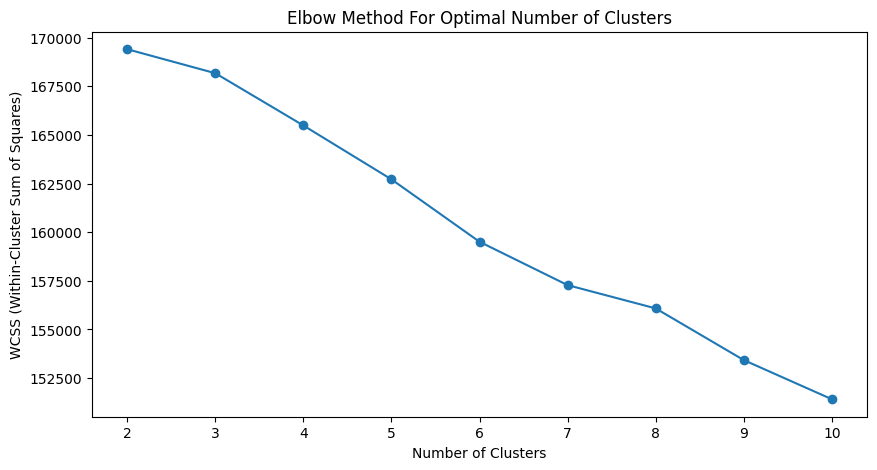

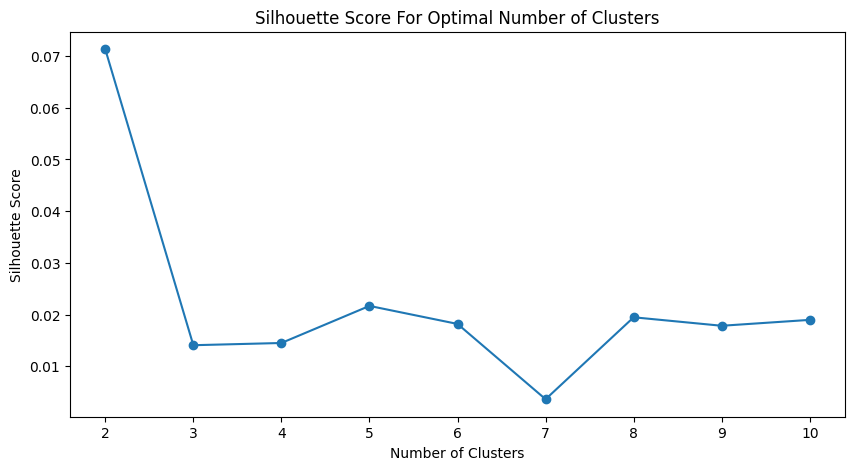

In [65]:
# Compute the Within-Cluster Sum of Squares (WCSS) and Silhouette Scores for a range of clusters
wcss = []
silhouette_scores = []
range_n_clusters = range(2, 11)  # Trying 2 to 10 clusters

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_normalized)
    
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_normalized, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the Elbow Method graph (WCSS)
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Plotting the Silhouette Score graph
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


### Apply K-Means Clustering

Based on the Elbow Method and Silhouette Score, I choose the optimal number of clusters and apply K-Means clustering to the SOM positions. I then merge the clustering results with the original results DataFrame for further analysis.

In [66]:
n_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
positions_df = pd.DataFrame(positions, columns=['x', 'y'])
positions_df['cluster'] = kmeans.fit_predict(positions_df)

# Merge clustering results with the original results_df
results_df['cluster'] = positions_df['cluster']


### Step 10: Visualize the Clusters on the SOM

I visualize the clusters on the SOM distance map using Plotly. Each cluster is represented by a different color, and detailed information about the diseases in each cluster is displayed on hover. Additionally, I save the disease information for each cluster to a CSV file for further analysis.

In [67]:
# Plot SOM distance map with Plotly
fig = go.Figure()

# Create a heatmap for the SOM distance map
distance_map = som.distance_map().T  # Transpose to align with Plotly's heatmap orientation
heatmap = go.Heatmap(
    z=distance_map,
    colorscale='cividis',
    colorbar=dict(title='Distance'),
    showscale=True,
)

# Add the heatmap to the figure
fig.add_trace(heatmap)

# Add clusters as scatter points with detailed hover labels
for cluster in range(n_clusters):
    cluster_data = results_df[results_df['cluster'] == cluster]
    hover_texts = []
    
    for _, row in cluster_data.iterrows():
        snp_details = "<br>".join([
            f"SNP: {snp}, Odds Ratio: {or_value:.2f}, P-Value: {p:.4f}"
            for snp, or_value, p in zip(row['snps'], row['odds_ratios'], row['p_values'])
        ])
        
        hover_text = (
            f"Disease: {row['phewas_string']}<br>"
            f"{snp_details}"
        )
        hover_texts.append(hover_text)
    
    fig.add_trace(go.Scatter(
        x=cluster_data['x'] + 0.5,
        y=cluster_data['y'] + 0.5,
        mode='markers',
        marker=dict(
            size=10,
            color=px.colors.qualitative.Dark24[cluster],  # Different color for each cluster
            opacity=0.8,
        ),
        text=hover_texts,
        hoverinfo='text'
    ))


fig.update_layout(
    title='SOM Clusters of Diseases with Detailed Hover Information',
    xaxis=dict(title='SOM X', showgrid=False, zeroline=False),
    yaxis=dict(title='SOM Y', showgrid=False, zeroline=False),
    plot_bgcolor='black',
    height=800,
    width=800,
    legend=dict(
        x=1.06,  # Move the legend slightly outside the plot area
        y=0.7,     # Align legend to the top
        bgcolor='rgba(0,0,0,0)'  # Make the legend background transparent
    )
)

# Update colorbar size and position
fig.data[0].colorbar.update(
    thickness=15,  # Adjust the thickness of the colorbar
    x=1.005,         # Move the colorbar slightly to the left
    len=0.8        # Adjust the length of the colorbar
)

# Show the figure
fig.show()

# Save each cluster's disease information to a CSV file
for cluster in range(n_clusters):
    print(f"Saving cluster {cluster} to CSV...")
    cluster_data = results_df[results_df['cluster'] == cluster]
    cluster_data.to_csv(f'outputs/clusters/phenotype_cluster_{cluster}.csv', index=False)


Saving cluster 0 to CSV...
Saving cluster 1 to CSV...
Saving cluster 2 to CSV...
Saving cluster 3 to CSV...
Saving cluster 4 to CSV...
